# Computer Vision

## Assignment 2

Vedansh Agrawal <br>
2021112010

## Question 1: SIFT-BoVW-SVM

### Part 1:

The task is to implement SIFT and use the BoVW method to find cluster centres followed by SVMs to do the classification task.


In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from tqdm import tqdm
import math
import cv2
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
np.random.seed(42)

train_dataset = torchvision.datasets.MNIST(root='./data', train = True, transform = transforms.ToTensor(), download = True)
test_dataset = torchvision.datasets.MNIST(root='./data', train = False, transform = transforms.ToTensor())

train_loader = DataLoader(dataset = train_dataset, batch_size = 100, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 1000, shuffle = False)

In order to implement the SIFT-BoVW-SVM, let us make some functions which will create descriptors for us as well as find cluster centres for the visual bag of words and then make histograms given an image

In [3]:
def keypoints_and_descriptors(image, contrast = 0.04, edge = 10, sigma = 1.6):
    image = image.numpy().squeeze() * 255 
    image = np.uint8(image)
    sift = cv2.SIFT_create(contrastThreshold=contrast, edgeThreshold=edge, sigma=sigma)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def compute_visual_words(descriptors, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(descriptors)
    return kmeans.cluster_centers_, kmeans

def compute_histogram(descriptors, kmeans, visual_words):
    histogram = np.zeros(len(visual_words))
    if descriptors is not None:
        labels = kmeans.predict(descriptors)
        for label in labels:
            histogram[label] += 1
    return histogram

def train_svm(features, labels, loss='squared_hinge'):
    svm = LinearSVC(loss = loss)
    svm.fit(features, labels)
    return svm

Now we will use these functions to run SIFT-BoVW-SVM using the following commands. Let us start by training the SVM on the training data.

### Part 2:

Now let us see how this model works for different num_cluster values and plot the accuracies that we obtain.

In [4]:
num_clusters = [1, 3, 10, 30, 100, 300]
accuracies = []

for N in tqdm(num_clusters):
    #TRAINING
    descriptors = []
    labels = []

    for image, label in zip(train_dataset.data, train_dataset.targets):
        keypoints, descriptor = keypoints_and_descriptors(image)
        if descriptor is not None:
            descriptors.append(descriptor)
        labels.append(label)


    descriptors = np.array(np.vstack(descriptors))
    labels = np.array(labels)

    visual_words, kmeans = compute_visual_words(descriptors, N)
    histograms = []

    for image, label in zip(train_dataset.data, train_dataset.targets):
        keypoints, descriptor = keypoints_and_descriptors(image)
        histogram = compute_histogram(descriptor, kmeans, visual_words)
        histograms.append(histogram)

    svm = train_svm(histograms, labels)

    #EVALUATION
    correct = 0
    total = 0

    for images, labels in test_loader:
        histograms_eval = []
        for image in images:
            keypoints, descriptor = keypoints_and_descriptors(image)
            histogram = compute_histogram(descriptor, kmeans, visual_words)
            histograms_eval.append(histogram)

        labels = np.array(labels)

        outputs = svm.predict(histograms_eval)
        total += labels.shape[0]
        correct += (outputs == labels).sum().item()

    accuracy = correct/total
    accuracies.append(accuracy)

  0%|          | 0/6 [00:00<?, ?it/s]/home/vedansh/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 17%|█▋        | 1/6 [01:28<07:21, 88.34s/it]/home/vedansh/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the 

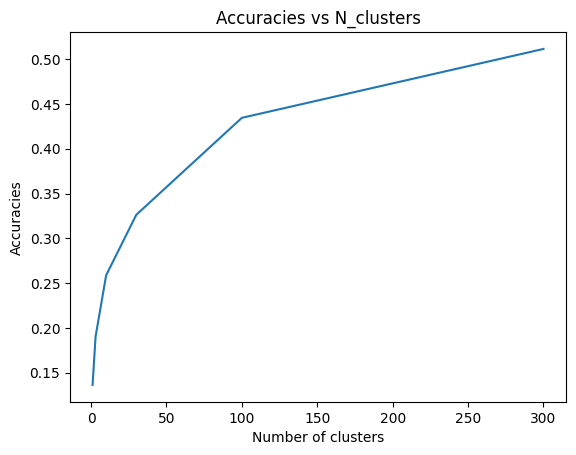

In [5]:
plt.plot(num_clusters, accuracies)
plt.xlabel('Number of clusters')
plt.ylabel('Accuracies')
plt.title('Accuracies vs N_clusters')
plt.show()

Here we can observe that from incresing the number of clusters the accuracy of the model also increases. So for the next task we will keep the number of clusters to be 300.

Now let us vary the different parameters of the linear SVM and the SIFT.

In [6]:
loss = ['squared_hinge', 'hinge']
sift_params = [(0.01, 5, 1.0), (0.04, 10, 1.6), (0.08, 15, 2.0), (0.1, 20, 2.5)]
accuracies_hinged = []
accuracies_shinged = []

for i,los in tqdm(enumerate(loss)):
    for contrast, edge, sigma in tqdm(sift_params):

        descriptors = []
        labels = []

        for image, label in zip(train_dataset.data, train_dataset.targets):
            keypoints, descriptor = keypoints_and_descriptors(image, contrast=contrast, edge=edge, sigma=sigma)
            if descriptor is not None:
                descriptors.append(descriptor)
            labels.append(label)


        descriptors = np.array(np.vstack(descriptors))
        labels = np.array(labels)

        visual_words, kmeans = compute_visual_words(descriptors, N)
        histograms = []

        for image, label in zip(train_dataset.data, train_dataset.targets):
            keypoints, descriptor = keypoints_and_descriptors(image, contrast=contrast, edge=edge, sigma=sigma)
            histogram = compute_histogram(descriptor, kmeans, visual_words)
            histograms.append(histogram)

        svm = train_svm(histograms, labels, loss=los)

        #EVALUATION
        correct = 0
        total = 0

        for images, labels in test_loader:
            histograms_eval = []
            for image in images:
                keypoints, descriptor = keypoints_and_descriptors(image, contrast=contrast, edge=edge, sigma=sigma)
                histogram = compute_histogram(descriptor, kmeans, visual_words)
                histograms_eval.append(histogram)

            labels = np.array(labels)

            outputs = svm.predict(histograms_eval)
            total += labels.shape[0]
            correct += (outputs == labels).sum().item()

        accuracy = correct/total
        if i == 0:
            accuracies_shinged.append(accuracy)
        else:
            accuracies_hinged.append(accuracy)

0it [00:00, ?it/s]/home/vedansh/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/vedansh/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value o

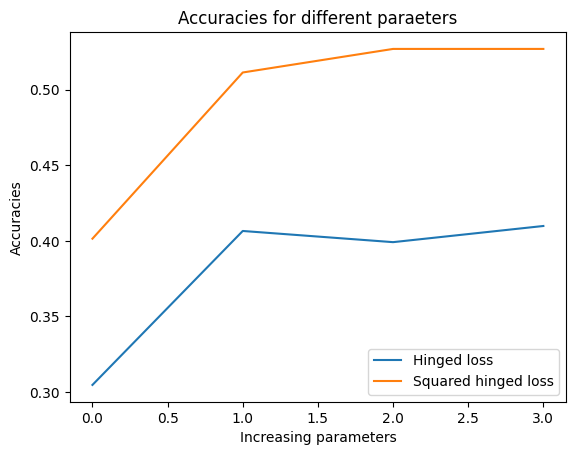

In [13]:
sift_labels = ['(0.01, 5, 1.0)', '(0.04, 10, 1.6)', '(0.08, 15, 2.0)', '(0.1, 20, 2.5)']
plt.plot(range(len(accuracies_hinged)), accuracies_hinged, label = 'Hinged loss')
plt.plot(range(len(accuracies_shinged)), accuracies_shinged, label = 'Squared hinged loss')
plt.xlabel('Increasing parameters')
plt.ylabel('Accuracies')
plt.title('Accuracies for different paraeters')
plt.legend()


As we can see, the loss, squared hinged loss, is clearly a much better choice, along with that its better to increase the thresholds for better classification as better features are extracted.

### Question 2: CNNs and Transformers 

### Part 1:

We are required to implement the LeNet architecture and train it on MNIST.

Here are 5 images from every class

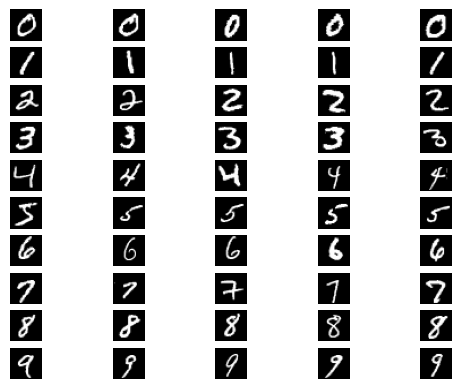

In [29]:
for i in range(10):
    indicies = np.where(train_dataset.targets.numpy() == i)[0][:5]
    for k, j in enumerate(indicies):
        plt.subplot(10, 5, 5*i + k + 1)
        plt.imshow(train_dataset.data[j], cmap='gray')
        plt.axis('off')

plt.show()

Now we will make the class for the LeNet Architecture


In [30]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0), nn.BatchNorm2d(6), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(256, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

### Part 2:

We need to run the training loop and the evaluation loop for 6 different Hyper parameter settings.

100%|██████████| 10/10 [01:20<00:00,  8.01s/it]


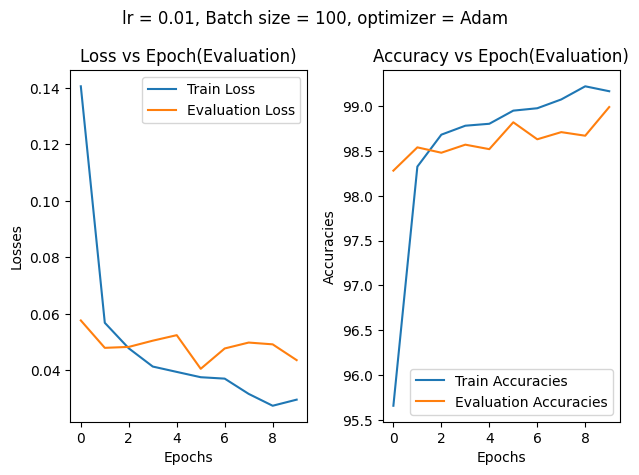

100%|██████████| 10/10 [01:12<00:00,  7.27s/it]


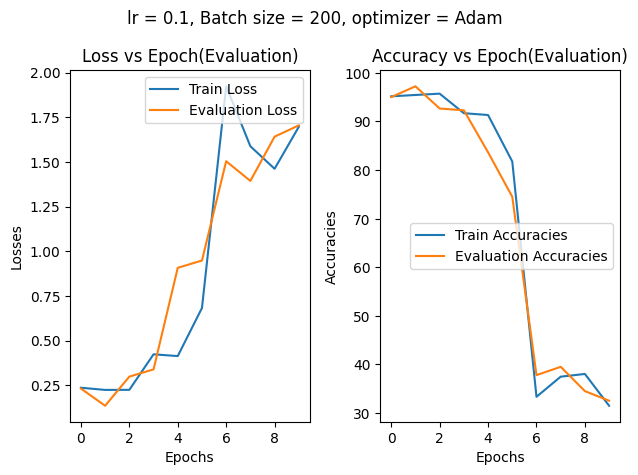

100%|██████████| 10/10 [01:13<00:00,  7.35s/it]


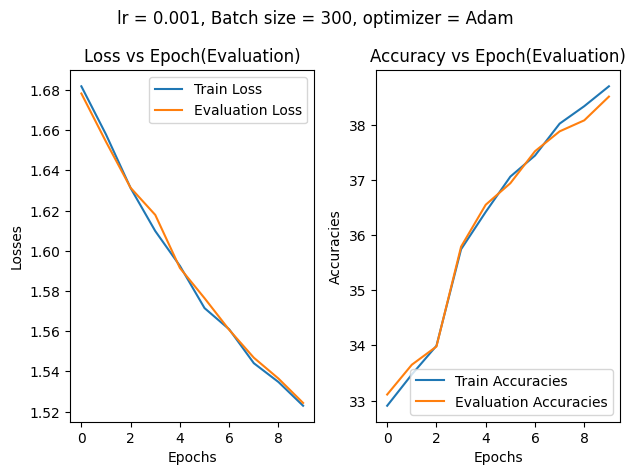

100%|██████████| 10/10 [01:17<00:00,  7.77s/it]


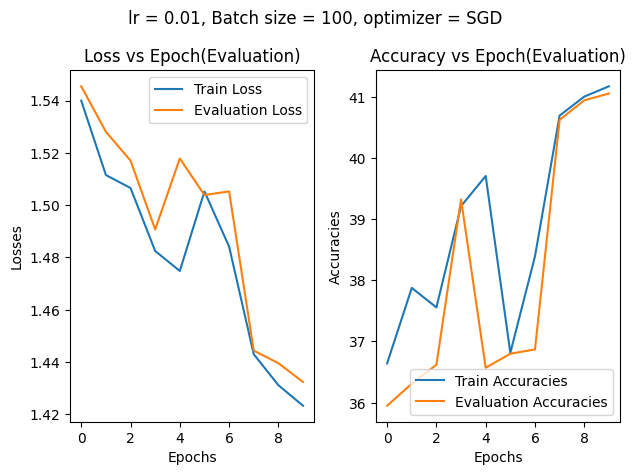

100%|██████████| 10/10 [01:12<00:00,  7.23s/it]


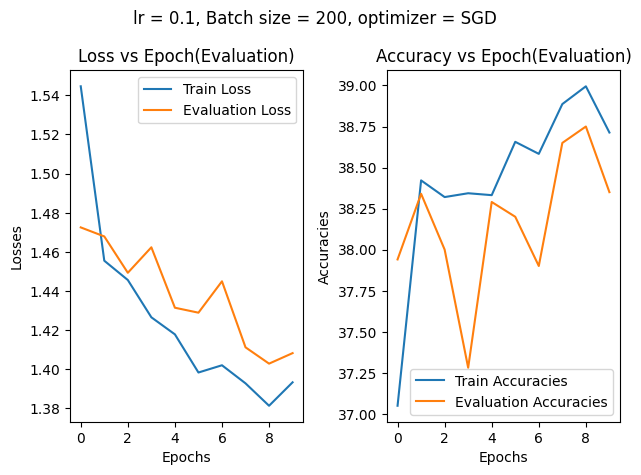

100%|██████████| 10/10 [01:30<00:00,  9.02s/it]


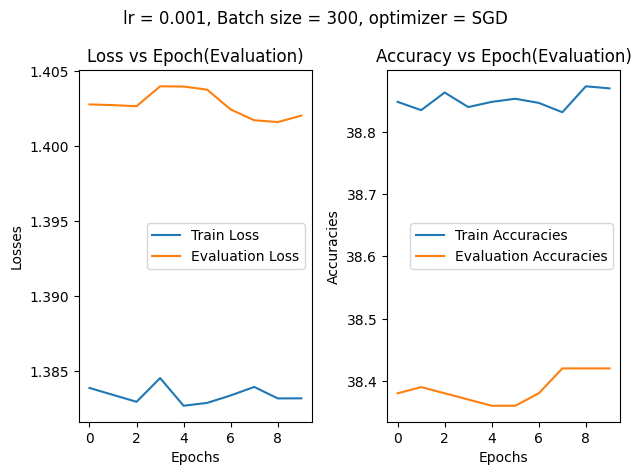

In [35]:
learning_and_batch = [(0.01, 100), (0.1, 200), (0.001, 300)]   

num_epochs = 10
model = LeNet()

for i in range(2):
    for (learning_rate, batch_size) in learning_and_batch: 

        train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
        test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

        criterion = nn.CrossEntropyLoss()

        if i == 0:
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        else:
            optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

        total_loss = 0
        n_correct = 0
        n_samples = 0
        accuracies_train = []
        losses_train = []
        accuracies = []
        losses = []

        

        # TRAINING LOOP
        for epoch in tqdm(range(num_epochs)):
            n_total_steps = len(train_loader)
            for (images, labels) in train_loader:

                output = model(images)

                _, predicted = torch.max(output, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()

                loss = criterion(output, labels)
                total_loss += loss.item()
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


            accuracies_train.append(100.0 * n_correct/n_samples)
            n_correct = 0
            n_samples = 0
            losses_train.append(total_loss/n_total_steps)
            total_loss = 0


            with torch.no_grad():
                n_total_steps = len(test_loader)

                for (images, labels) in test_loader:
                    outputs = model(images)

                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels.size(0)
                    n_correct += (predicted == labels).sum().item()

                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
            
            accuracies.append(100.0 * n_correct/n_samples)
            n_correct = 0
            n_samples = 0
            losses.append(total_loss/n_total_steps)
            total_loss = 0



        # PLOTS FOR TRAINING STEP
        fig, axs = plt.subplots(1, 2)

        axs[0].plot(range(len(losses_train)), losses_train, label = 'Train Loss')
        axs[0].set_title(f'Loss vs Epoch(Training)')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')

        axs[1].plot(range(len(accuracies_train)), accuracies_train, label = 'Train Accuracies')
        axs[1].set_title('Accuracy vs Epoch(Training)')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracies')


        #PLOTS FOR EVALUATION STEP
        axs[0].plot(range(len(losses)), losses, label = 'Evaluation Loss')
        axs[0].set_title('Loss vs Epoch(Evaluation)')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Losses')

        axs[1].plot(range(len(accuracies)), accuracies, label = 'Evaluation Accuracies')
        axs[1].set_title('Accuracy vs Epoch(Evaluation)')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracies')

        axs[0].legend()
        axs[1].legend()

        fig.suptitle(f"lr = {learning_rate}, Batch size = {batch_size}, optimizer = {optimizer.__class__.__name__}")

        plt.tight_layout()
        plt.show()

Let us observe the above plots for different parameters. First we can see that the contour for adam optimizer is more smoother than that of the SGD optimizer. Despite the choice of optimizer, we can see that higher learning rates gives increasing looses. Keepig a lower batch size can also allow the losses to converge faster. But from all of this, we can tell that the optimizer and learning rate are really important factors for better learning. We can tell that the best set of parameters would be lr = 0.001 and batch size 100 with adam optimizer.

### Part 4:

Here we will see how the performance changes when we double the number of convolution layers. Following is the LeNet architecture with 2 more convolutional layers.

In [36]:
class LeNet1(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet1, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0), nn.BatchNorm2d(6), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(nn.Conv2d(16, 30, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(30), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer4 = nn.Sequential(nn.Conv2d(30,40, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(40), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(40, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

100%|██████████| 10/10 [01:56<00:00, 11.63s/it]


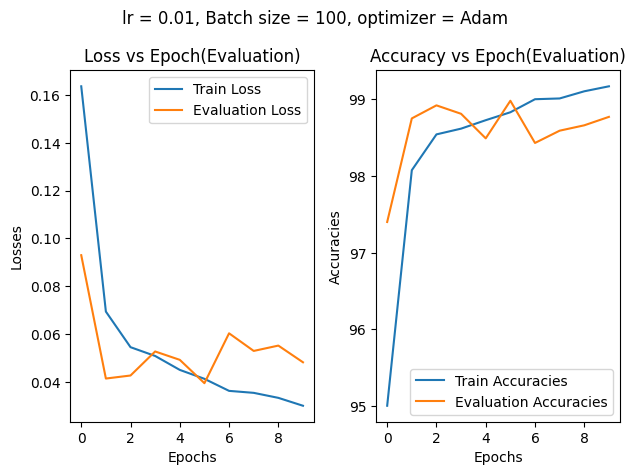

100%|██████████| 10/10 [01:38<00:00,  9.87s/it]


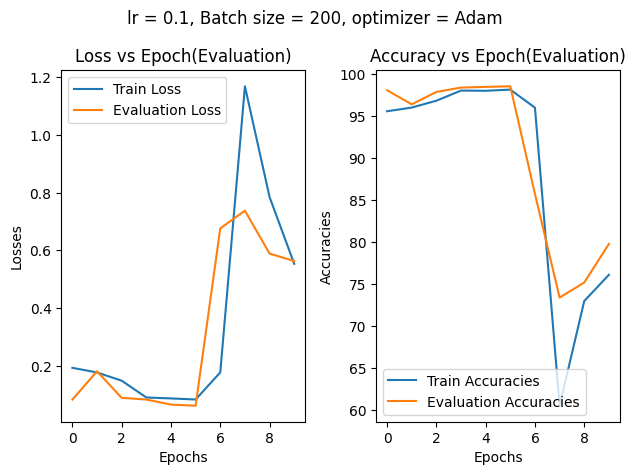

100%|██████████| 10/10 [01:30<00:00,  9.10s/it]


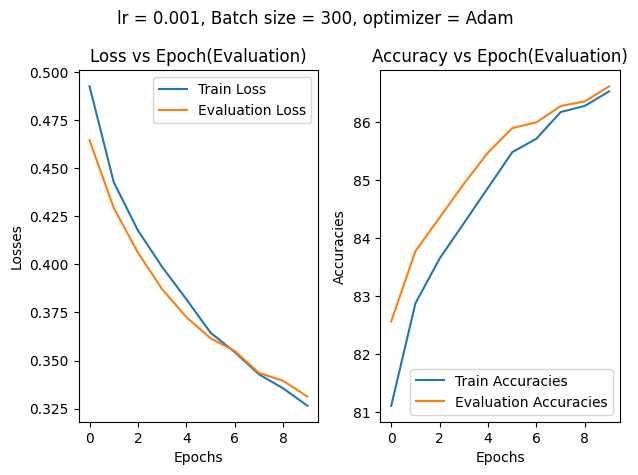

100%|██████████| 10/10 [01:32<00:00,  9.28s/it]


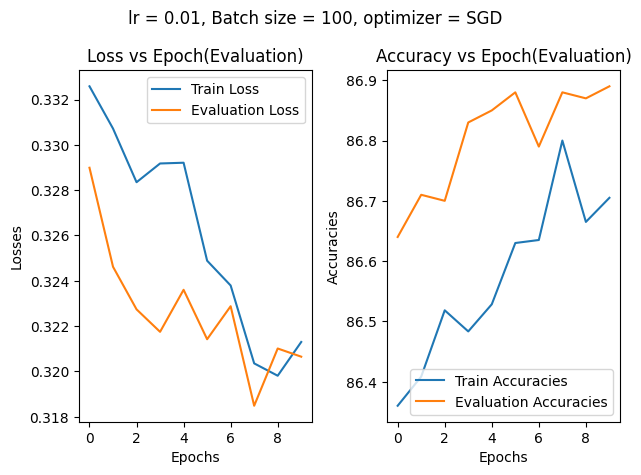

100%|██████████| 10/10 [01:27<00:00,  8.76s/it]


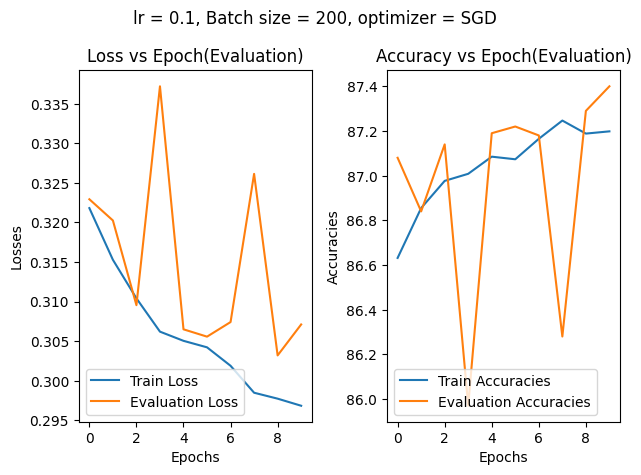

100%|██████████| 10/10 [01:23<00:00,  8.39s/it]


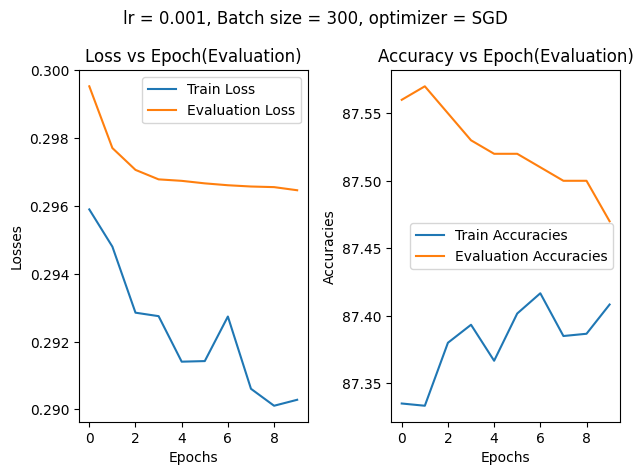

In [37]:
learning_and_batch = [(0.01, 100), (0.1, 200), (0.001, 300)]   

num_epochs = 10
model = LeNet1()

for i in range(2):
    for (learning_rate, batch_size) in learning_and_batch: 

        train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
        test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

        criterion = nn.CrossEntropyLoss()

        if i == 0:
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        else:
            optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

        total_loss = 0
        n_correct = 0
        n_samples = 0
        accuracies_train = []
        losses_train = []
        accuracies = []
        losses = []

        

        # TRAINING LOOP
        for epoch in tqdm(range(num_epochs)):
            n_total_steps = len(train_loader)
            for (images, labels) in train_loader:

                output = model(images)

                _, predicted = torch.max(output, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()

                loss = criterion(output, labels)
                total_loss += loss.item()
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


            accuracies_train.append(100.0 * n_correct/n_samples)
            n_correct = 0
            n_samples = 0
            losses_train.append(total_loss/n_total_steps)
            total_loss = 0


            with torch.no_grad():
                n_total_steps = len(test_loader)

                for (images, labels) in test_loader:
                    outputs = model(images)

                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels.size(0)
                    n_correct += (predicted == labels).sum().item()

                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
            
            accuracies.append(100.0 * n_correct/n_samples)
            n_correct = 0
            n_samples = 0
            losses.append(total_loss/n_total_steps)
            total_loss = 0



        # PLOTS FOR TRAINING STEP
        fig, axs = plt.subplots(1, 2)

        axs[0].plot(range(len(losses_train)), losses_train, label = 'Train Loss')
        axs[0].set_title(f'Loss vs Epoch(Training)')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')

        axs[1].plot(range(len(accuracies_train)), accuracies_train, label = 'Train Accuracies')
        axs[1].set_title('Accuracy vs Epoch(Training)')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracies')


        #PLOTS FOR EVALUATION STEP
        axs[0].plot(range(len(losses)), losses, label = 'Evaluation Loss')
        axs[0].set_title('Loss vs Epoch(Evaluation)')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Losses')

        axs[1].plot(range(len(accuracies)), accuracies, label = 'Evaluation Accuracies')
        axs[1].set_title('Accuracy vs Epoch(Evaluation)')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracies')

        axs[0].legend()
        axs[1].legend()

        fig.suptitle(f"lr = {learning_rate}, Batch size = {batch_size}, optimizer = {optimizer.__class__.__name__}")

        plt.tight_layout()
        plt.show()

As we can see, increasing the number of CNN layers does not effect the performance that much since the relevant features extracted will still be the same.

### Part 5:

Now let us check the performance of training with different training samples size.

100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


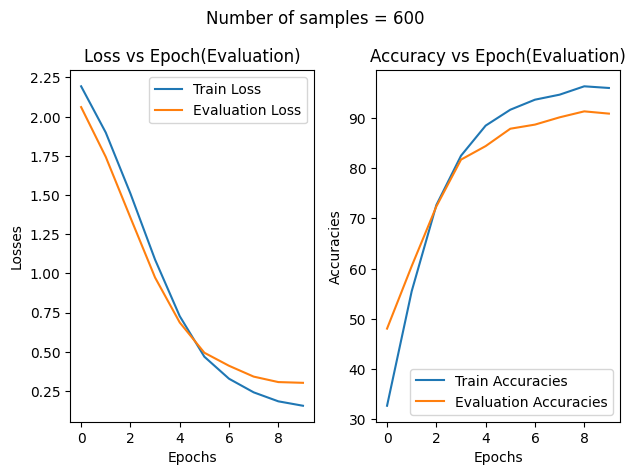

100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


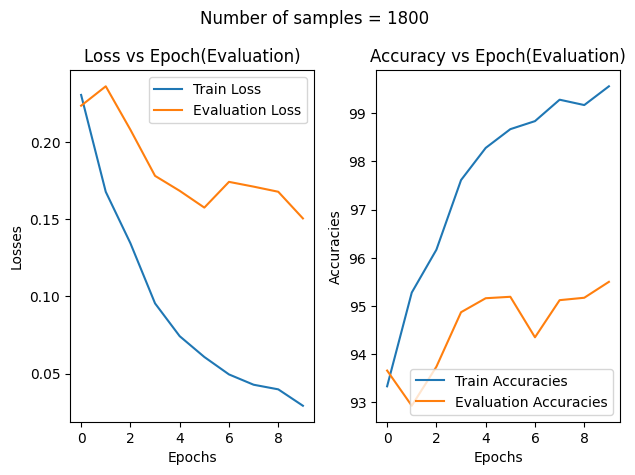

100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


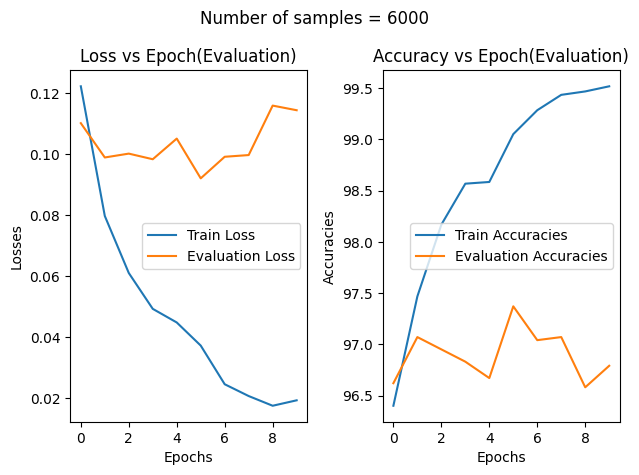

100%|██████████| 10/10 [00:35<00:00,  3.50s/it]


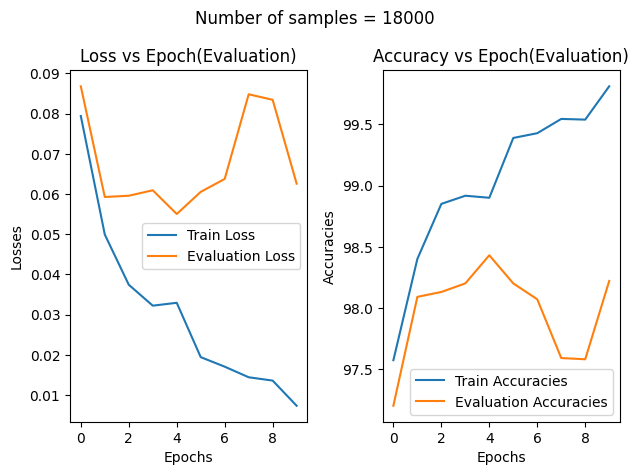

100%|██████████| 10/10 [01:36<00:00,  9.61s/it]


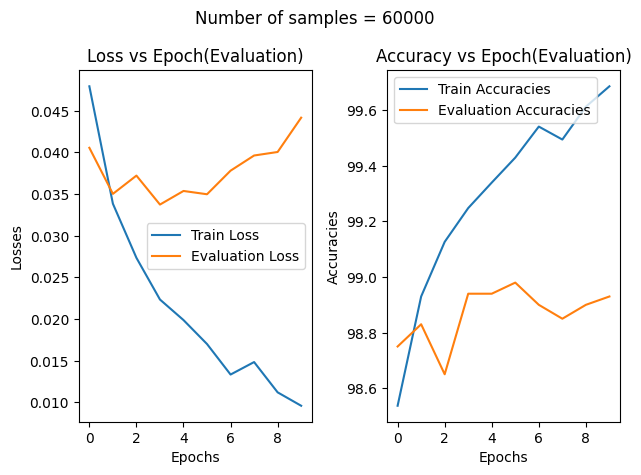

In [53]:
learning_rate = 0.001
batch_size = 100
number_of_samples = [600, 1800, 6000, 18000, 60000]

num_epochs = 10
model = LeNet()
for N in number_of_samples:

    train_subset = Subset(train_dataset, range(N))

    train_loader = DataLoader(dataset = train_subset, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    total_loss = 0
    n_correct = 0
    n_samples = 0
    accuracies_train = []
    losses_train = []
    accuracies = []
    losses = []

    

    # TRAINING LOOP
    for epoch in tqdm(range(num_epochs)):
        n_total_steps = len(train_loader)
        for (images, labels) in train_loader:

            output = model(images)

            _, predicted = torch.max(output, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            loss = criterion(output, labels)
            total_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        accuracies_train.append(100.0 * n_correct/n_samples)
        n_correct = 0
        n_samples = 0
        losses_train.append(total_loss/n_total_steps)
        total_loss = 0


        with torch.no_grad():
            n_total_steps = len(test_loader)

            for (images, labels) in test_loader:
                outputs = model(images)

                _, predicted = torch.max(outputs, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                total_loss += loss.item()
        
        accuracies.append(100.0 * n_correct/n_samples)
        n_correct = 0
        n_samples = 0
        losses.append(total_loss/n_total_steps)
        total_loss = 0



    # PLOTS FOR TRAINING STEP
    fig, axs = plt.subplots(1, 2)

    axs[0].plot(range(len(losses_train)), losses_train, label = 'Train Loss')
    axs[0].set_title(f'Loss vs Epoch(Training)')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')

    axs[1].plot(range(len(accuracies_train)), accuracies_train, label = 'Train Accuracies')
    axs[1].set_title('Accuracy vs Epoch(Training)')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracies')


    #PLOTS FOR EVALUATION STEP
    axs[0].plot(range(len(losses)), losses, label = 'Evaluation Loss')
    axs[0].set_title('Loss vs Epoch(Evaluation)')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Losses')

    axs[1].plot(range(len(accuracies)), accuracies, label = 'Evaluation Accuracies')
    axs[1].set_title('Accuracy vs Epoch(Evaluation)')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracies')

    axs[0].legend()
    axs[1].legend()

    fig.suptitle(f"Number of samples = {N}")

    plt.tight_layout()
    plt.show()

As we can observe from the plots, the more number of training samples there are, the better the loss reduces as well. The best convergence of loss happens for 60k training samples.

### Part 6:

Now, let us replace the above CNN with a visual transformer and verify the results. TFor this we need to mzke 2 classes, one for the Vit and one for the positional encodings.

In [54]:
class TransformerModel(nn.Module):
    def __init__(self, hidden_dim = 64, output_dim = 10, num_layers=2, nhead=1):
        super(TransformerModel, self).__init__()
        self.patch_embed = nn.Conv2d(1, hidden_dim, kernel_size=4, stride=4)  
        self.pos_encoder = PositionalEncoding(hidden_dim, dropout=0.1) 
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(1) 
        x = self.fc(x)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.input_size = d_model

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe.view(1, -1, self.input_size)[:, :x.size(1), :]
        return self.dropout(x)

100%|██████████| 20/20 [09:24<00:00, 28.22s/it]


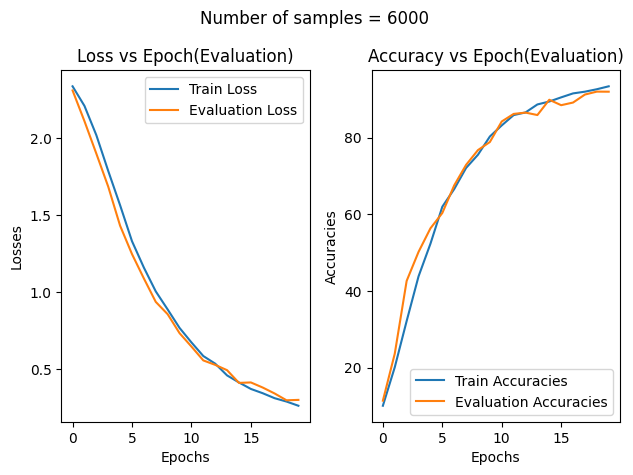

100%|██████████| 20/20 [50:13<00:00, 150.66s/it]


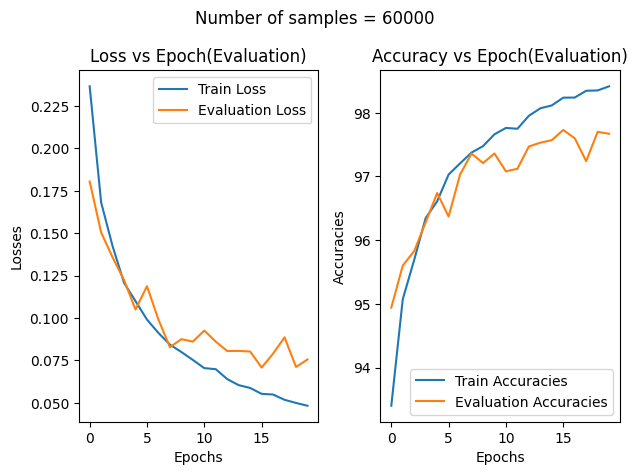

In [55]:
learning_rate = 0.001
batch_size = 100
number_of_samples = [6000,60000]

num_epochs = 20
model = TransformerModel()
for N in number_of_samples:

    train_subset = Subset(train_dataset, range(N))

    train_loader = DataLoader(dataset = train_subset, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    total_loss = 0
    n_correct = 0
    n_samples = 0
    accuracies_train = []
    losses_train = []
    accuracies = []
    losses = []

    

    # TRAINING LOOP
    for epoch in tqdm(range(num_epochs)):
        n_total_steps = len(train_loader)
        for (images, labels) in train_loader:

            output = model(images)

            _, predicted = torch.max(output, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            loss = criterion(output, labels)
            total_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        accuracies_train.append(100.0 * n_correct/n_samples)
        n_correct = 0
        n_samples = 0
        losses_train.append(total_loss/n_total_steps)
        total_loss = 0


        with torch.no_grad():
            n_total_steps = len(test_loader)

            for (images, labels) in test_loader:
                outputs = model(images)

                _, predicted = torch.max(outputs, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                total_loss += loss.item()
        
        accuracies.append(100.0 * n_correct/n_samples)
        n_correct = 0
        n_samples = 0
        losses.append(total_loss/n_total_steps)
        total_loss = 0



    # PLOTS FOR TRAINING STEP
    fig, axs = plt.subplots(1, 2)

    axs[0].plot(range(len(losses_train)), losses_train, label = 'Train Loss')
    axs[0].set_title(f'Loss vs Epoch(Training)')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')

    axs[1].plot(range(len(accuracies_train)), accuracies_train, label = 'Train Accuracies')
    axs[1].set_title('Accuracy vs Epoch(Training)')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracies')


    #PLOTS FOR EVALUATION STEP
    axs[0].plot(range(len(losses)), losses, label = 'Evaluation Loss')
    axs[0].set_title('Loss vs Epoch(Evaluation)')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Losses')

    axs[1].plot(range(len(accuracies)), accuracies, label = 'Evaluation Accuracies')
    axs[1].set_title('Accuracy vs Epoch(Evaluation)')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracies')

    axs[0].legend()
    axs[1].legend()

    fig.suptitle(f"Number of samples = {N}")

    plt.tight_layout()
    plt.show()

As we can see, the accuracy increases with increasing number of training samples. Comapred to the CNN architcture, it performs more or less similar and this is beacuse of the problem is relatively more simpler, that is digit classification. Say we were to compare the 2 models to a more complicated task such as image classification on the CIFAR10 dataset, then we can see, the CNN performing a little poorer than the transformer ViT.